In [66]:
import fnmatch
import os
import random
import shutil
import string
import time
from abc import abstractmethod
from collections import defaultdict
from time import sleep

import numpy as np
from monai.transforms import AddChannel, Compose, Resize, ScaleIntensity, ToTensor
from torch.utils.data import DataLoader, Dataset


def get_transforms_2d(target_size=128):
    """Returns a Transform which resizes 2D samples (1xHxW) to a target_size (1 x target_size x target_size)
    and then converts them to a pytorch tensor.
    Args:
        target_size (int, optional): [New spatial dimension of the input data]. Defaults to 128.
    Returns:
        [Transform]
    """

    transforms = Compose([Resize((target_size, target_size)), ToTensor()])
    return transforms


def get_transforms_3d(target_size=128):
    """Returns a Transform which resizes 3D samples (1xZxYxX) to a target_size (1 x target_size x target_size x target_size)
    and then converts them to a pytorch tensor.
    Args:
        target_size (int, optional): [New spatial dimension of the input data]. Defaults to 128.
    Returns:
        [Transform]
    """
    transforms = Compose([Resize((target_size, target_size, target_size)), ToTensor()])
    return transforms


def get_numpy2d_dataset(
    base_dir,
    mode="train",
    batch_size=16,
    n_items=None,
    pin_memory=False,
    num_processes=1,
    drop_last=False,
    target_size=512,
    file_pattern="*data.npy",
    do_reshuffle=True,
    slice_offset=0,
    caching=True,
):
    """Returns a Pytorch data loader which loads a Numpy2dDataSet, i.e. 2D slices from a dir of 3D Numpy arrays.
    Args:
        base_dir ([str]): [Directory in which the npy files are.]
        mode (str, optional): [train or val, loads the first 90% for train and 10% for val]. Defaults to "train".
        batch_size (int, optional): [See pytorch DataLoader]. Defaults to 16.
        n_items ([int], optional): [Number of items in on interation, by default number of files in the loaded set 
                                        but can be smaller (uses subset) or larger (uses file multiple times)]. Defaults to None.
        pin_memory (bool, optional): [See pytorch DataLoader]. Defaults to False.
        num_processes (int, optional): [See pytorch DataLoader]. Defaults to 1.
        drop_last (bool, optional): [See pytorch DataLoader]. Defaults to False.
        target_size (int, optional): [New spatial dimension of to which the input data will be transformed]. Defaults to 128.
        file_pattern (str, optional): [File pattern of files to load from the base_dir]. Defaults to "*data.npy".
        do_reshuffle (bool, optional): [See pytorch DataLoader]. Defaults to True.
        slice_offset (int, optinal): [Offset for the first dimension to skip the first/last n slices]. Defaults to 0.
        caching (bool, optinal): [If True saves the data set list to a file in the base_dir
                                    so files don't have to be indexed again and can be more quickly loaded using the cache file]. Defaults to True.
    Returns:
        [DataLoader]: Pytorch data loader which loads a Numpy2dDataSet
    """

    transforms = get_transforms_2d(target_size=target_size)

    data_set = Numpy2dDataSet(
        base_dir=base_dir,
        mode=mode,
        n_items=n_items,
        file_pattern=file_pattern,
        slice_offset=slice_offset,
        caching=caching,
        transforms=transforms,
    )

    data_loader = DataLoader(
        data_set,
        batch_size=batch_size,
        shuffle=do_reshuffle,
        num_workers=num_processes,
        pin_memory=pin_memory,
        drop_last=drop_last,
    )
    return data_loader


def get_numpy3d_dataset(
    base_dir,
    mode="train",
    batch_size=16,
    n_items=None,
    pin_memory=False,
    num_processes=1,
    drop_last=False,
    target_size=128,
    file_pattern="*data.npy",
    do_reshuffle=True,
):
    """Returns a Pytorch data loader which loads a Numpy3dDataSet, i.e. 3D Numpy arrays from a directory.
    Args:
        base_dir ([str]): [Directory in which the npy files are.]
        mode (str, optional): [train or val, loads the first 90% for train and 10% for val]. Defaults to "train".
        batch_size (int, optional): [See pytorch DataLoader]. Defaults to 16.
        n_items ([int], optional): [Number of items in on interation, by default number of files in the loaded set 
                                        but can be smaller (uses subset) or larger (uses file multiple times)]. Defaults to None.
        pin_memory (bool, optional): [See pytorch DataLoader]. Defaults to False.
        num_processes (int, optional): [See pytorch DataLoader]. Defaults to 1.
        drop_last (bool, optional): [See pytorch DataLoader]. Defaults to False.
        target_size (int, optional): [New spatial dimension of to which the input data will be transformed]. Defaults to 128.
        file_pattern (str, optional): [File pattern of files to load from the base_dir]. Defaults to "*data.npy".
        do_reshuffle (bool, optional): [See pytorch DataLoader]. Defaults to True.
    Returns:
        [DataLoader]: Pytorch data loader which loads a Numpy3dDataSet
    """

    transforms = get_transforms_3d(target_size=target_size)

    data_set = Numpy3dDataSet(
        base_dir=base_dir, mode=mode, n_items=n_items, file_pattern=file_pattern, transforms=transforms,
    )

    data_loader = DataLoader(
        data_set,
        batch_size=batch_size,
        shuffle=do_reshuffle,
        num_workers=num_processes,
        pin_memory=pin_memory,
        drop_last=drop_last,
    )
    return data_loader


class Numpy2dDataSet(Dataset):
    def __init__(
        self,
        base_dir,
        mode="train",
        n_items=None,
        file_pattern="*data.npy",
        slice_offset=0,
        caching=True,
        transforms=None,
    ):
        """Dataset which loads 2D slices from a dir of 3D Numpy arrays.
        Args:
            base_dir ([str]): [Directory in which the npy files are.]
            mode (str, optional): [train or val, loads the first 90% for train and 10% for val]. Defaults to "train".
            n_items ([type], optional): [Number of items in on interation, by default number of files in the loaded set 
                                        but can be smaller (uses subset) or larger (uses file multiple times)]. Defaults to None.
            file_pattern (str, optional): [File pattern of files to load from the base_dir]. Defaults to "*data.npy".
            slice_offset (int, optinal): [Offset for the first dimension to skip the first/last n slices]. Defaults to 0.
            caching (bool, optinal): [If True saves the data set list to a file in the base_dir
                                        so files don't have to be indexed again and can be more quickly loaded using the cache file]. Defaults to True.
            transforms ([type], optional): [Transformation to do after loading the dataset -> pytorch data transforms]. Defaults to Non
        """

        self.base_dir = base_dir
        self.items = self.load_dataset(
            base_dir, mode=mode, pattern=file_pattern, slice_offset=slice_offset, caching=caching
        )
        self.transforms = transforms

        self.data_len = len(self.items)
        if n_items is None:
            self.n_items = self.data_len
        else:
            self.n_items = int(n_items)

        self.reshuffle()

    def reshuffle(self):
        print("Reshuffle...")
        random.shuffle(self.items)
        self.items.sort(key=lambda x: x[0])

    def __len__(self):
        return self.n_items

    def __getitem__(self, item):

        if item >= self.n_items:
            raise StopIteration()

        idx = item % self.data_len
        data_smpl = self.get_data_by_idx(idx)

        if self.transforms is not None:
            data_smpl = self.transforms(data_smpl)

        return data_smpl

    def get_data_by_idx(self, idx):
        """Returns a data sample for a given index , i.e. a Np-Array slice  
        Args:
            idx ([int]): [Index of the data sample]
        Returns:
            [np.ndarray]: [3-D Numpy array 1xHxW]
        """

        slice_info = self.items[idx]
        fn_name = slice_info[1]
        slice_idx = slice_info[2]

        numpy_array = np.load(fn_name, mmap_mode="r")
        numpy_slice = numpy_array[slice_idx : slice_idx + 1]

        del numpy_array

        return numpy_slice.astype(np.float32)

    def load_dataset(self, base_dir, mode="train", pattern="*data.npy", slice_offset=0, caching=True):
        """Indexes all files in the given directory and returns a list of 2-D slices (file_index, npy_file, slice_index_for_np_file)
          (so they can be loaded with get_data_by_idx)
        Args:
            base_dir ([str]): [Directory in which the npy files are.]
            mode (str, optional): [train or val, loads the first 90% for train and 10% for val]. Defaults to "train".
            file_pattern (str, optional): [File pattern of files to load from the base_dir]. Defaults to "*data.npy".
            slice_offset (int, optinal): [Offset for the first dimension to skip the first/last n slices]. Defaults to 0.
            caching (bool, optinal): [If True saves the data set list to a file in the base_dir
                                        so files don't have to be indexed again and can be more quickly loaded using the cache file]. Defaults to True.
        Returns:
            [list]: [List of (Numpy_file X slieces in the file) which should be used in the dataset]
        """
        slices = []

        if caching:
            cache_file = os.path.join(base_dir, f"cache_file_{mode}_{slice_offset}.lst")
            if os.path.exists(cache_file):
                slices = np.load(cache_file)
                return slices

        all_files = os.listdir(base_dir)
        npy_files = fnmatch.filter(all_files, pattern)
        n_files = len(npy_files)

        if mode == "train":
            load_files = npy_files[: int(0.9 * n_files)]
        elif mode == "val":
            load_files = npy_files[int(0.9 * n_files) :]
        else:
            load_files = []

        for i, filename in enumerate(sorted(load_files)):
            npy_file = os.path.join(base_dir, filename)
            numpy_array = np.load(npy_file, mmap_mode="r")

            file_len = numpy_array.shape[1]

            slices.extend([(i, npy_file, j) for j in range(slice_offset, file_len - slice_offset)])

        if caching:
            np.save(cache_file, slices)


        return slices


class Numpy3dDataSet(Dataset):
    def __init__(
        self, base_dir, mode="train", n_items=None, file_pattern="*data.npy", transforms=None,
    ):
        """A Datasets that loads 3D Numpy array from a (flat) directory
        Args:
            base_dir ([str]): [Directory in which the npy files are.]
            mode (str, optional): [train or val, loads the first 90% for train and 10% for val]. Defaults to "train".
            n_items ([type], optional): [Number of items in on interation, by default number of files in the loaded set 
                                        but can be smaller (uses subset) or larger (uses file multiple times)]. Defaults to None.
            file_pattern (str, optional): [File pattern of files to load from the base_dir]. Defaults to "*data.npy".
            transforms ([type], optional): [Transformation to do after loading the dataset -> pytorch data transforms]. Defaults to None.
        """

        self.base_dir = base_dir
        self.items = self.load_dataset(base_dir, mode=mode, pattern=file_pattern)
        self.transforms = transforms

        self.data_len = len(self.items)
        if n_items is None:
            self.n_items = self.data_len
        else:
            self.n_items = int(n_items)

    def reshuffle(self):
        print("Reshuffle...")
        random.shuffle(self.items)

    def __len__(self):
        return self.n_items

    def __getitem__(self, item):

        if item >= self.n_items:
            raise StopIteration()

        idx = item % self.data_len

        data_smpl = self.get_data_by_idx(idx)

        # if self.transforms is not None:
        #     data_smpl = self.transforms(data_smpl)

        return data_smpl

    def get_data_by_idx(self, idx):
        """Returns a data sample for a given index  
        Args:
            idx ([int]): [Index of the data sample]
        Returns:
            [np.ndarray]: [4-D Numpy array 1xCxHxW]
        """

        fn_name = self.items[idx]
        numpy_array = np.load(fn_name)
        print(fn_name)
        return numpy_array.astype(np.float32)[None]

    @staticmethod
    def load_dataset(base_dir, mode="train", pattern="*data.npy"):
        """Indexes all files in the given directory (so they can be loaded with get_data_by_idx)
        Args:
            base_dir ([str]): [Directory in which the npy files are.]
            mode (str, optional): [train or val, loads the first 90% for train and 10% for val]. Defaults to "train".
            file_pattern (str, optional): [File pattern of files to load from the base_dir]. Defaults to "*data.npy".
        Returns:
            [list]: [List of files which should be used in the dataset]
        """

        all_files = os.listdir(base_dir)
        npy_files = fnmatch.filter(all_files, pattern)
        n_files = len(npy_files)

        if mode == "train":
            load_files = npy_files[: int(0.9 * n_files)]
        elif mode == "val":
            load_files = npy_files[int(0.9 * n_files) :]
        else:
            load_files = []

        load_files = [os.path.join(base_dir, fn) for fn in load_files]

        return load_files

In [67]:
ds = Numpy3dDataSet("data/out",file_pattern="*.npy")

data/out\crossmoda2021_ldn_10_ceT1_81.npy
(1, 256, 256)
data/out\crossmoda2021_ldn_10_ceT1_1.npy


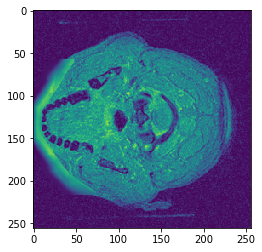

In [72]:
print(ds[100].shape)
npee = np.array(ds[1])
x = np.moveaxis(npee, 0,-1)
#x.shape

from matplotlib import pyplot as plt
plt.imshow(x, interpolation='nearest')
plt.show()